# Customer Growth and Retention Analysis

## Business Context
This notebook implements a comprehensive customer retention strategy for a fintech/subscription/e-commerce company facing high Customer Acquisition Cost (CAC), elevated churn rates among high-value customers, and inefficient mass retention campaigns.

**Objectives:**
- Reduce churn
- Maximize Customer Lifetime Value (CLV)
- Avoid over-treatment (spam) of customers who don't need retention

**Dataset:**
- `customers.csv`: Customer IDs, signup dates, true lifetime days
- `transactions.csv`: Transaction history with dates and amounts

**Approach:**
RFM analysis, churn prediction models, BG-NBD for transactional behavior, survival analysis for time-to-churn, and CLV modeling to prioritize retention efforts.

## Setup and Data Loading

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifelines import CoxPHFitter, WeibullFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette('husl')

In [3]:
# Load data
def load_customers(filepath='data/customers.csv'):
    df = pd.read_csv(filepath)
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    return df

def load_transactions(filepath='data/transactions.csv'):
    df = pd.read_csv(filepath)
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    return df

customers = load_customers()
transactions = load_transactions()

print("Customers shape:", customers.shape)
print("Transactions shape:", transactions.shape)
print("Observation date:", transactions['transaction_date'].max())

Customers shape: (3000, 3)
Transactions shape: (46704, 3)
Observation date: 2025-12-31 00:00:00


- The dataset contains 3,000 customers with 46,706 transactions observed up to December 31, 2025. This provides approximately 1 year of transactional data (15.6 transactions per customer on average), which is sufficient for robust RFM and CLV analysis. The data appears clean with proper datetime parsing.

- A dataset of this size and duration supports reliable customer segmentation and predictive modeling. The high transaction volume per customer suggests an engaged user base, but the observation date being in the future (2026) indicates this may be synthetic data for demonstration purposes. In real scenarios, ensure data covers at least 12-24 months for stable CLV estimates.

## Exploratory Data Analysis

**Objectives:**
- Understand data distributions and patterns
- Identify outliers and data quality issues
- Explore customer behavior patterns
- Visualize key metrics and relationships

**Analysis Focus:**
- Transaction patterns over time
- Customer demographics and behavior
- Amount distributions and correlations
- Temporal trends and seasonality

In [4]:
print("=== DATASET OVERVIEW ===")
print(f"Total customers: {customers.shape[0]}")
print(f"Total transactions: {transactions.shape[0]}")
print(f"Average transactions per customer: {transactions.shape[0]/customers.shape[0]:.1f}")
print(f"Date range: {transactions['transaction_date'].min()} to {transactions['transaction_date'].max()}")
print(f"Observation period: {(transactions['transaction_date'].max() - transactions['transaction_date'].min()).days} days")

print("\n=== CUSTOMER LIFETIME ANALYSIS ===")
observation_date = transactions['transaction_date'].max()
customers['lifetime_days'] = (observation_date - customers['signup_date']).dt.days
print(f"Average customer lifetime: {customers['lifetime_days'].mean():.1f} days")
print(f"Median customer lifetime: {customers['lifetime_days'].median():.1f} days")
print(f"Min/Max lifetime: {customers['lifetime_days'].min()}/{customers['lifetime_days'].max()} days")

print("\n=== TRANSACTION AMOUNT ANALYSIS ===")
print(f"Average transaction amount: ${transactions['amount'].mean():.2f}")
print(f"Median transaction amount: ${transactions['amount'].median():.2f}")
print(f"Total revenue: ${transactions['amount'].sum():.2f}")
print(f"Min/Max transaction: ${transactions['amount'].min():.2f}/${transactions['amount'].max():.2f}")

=== DATASET OVERVIEW ===
Total customers: 3000
Total transactions: 46704
Average transactions per customer: 15.6
Date range: 2025-01-03 00:00:00 to 2025-12-31 00:00:00
Observation period: 362 days

=== CUSTOMER LIFETIME ANALYSIS ===
Average customer lifetime: 195.7 days
Median customer lifetime: 192.0 days
Min/Max lifetime: 29/363 days

=== TRANSACTION AMOUNT ANALYSIS ===
Average transaction amount: $58.26
Median transaction amount: $40.78
Total revenue: $2721142.53
Min/Max transaction: $0.06/$887.83


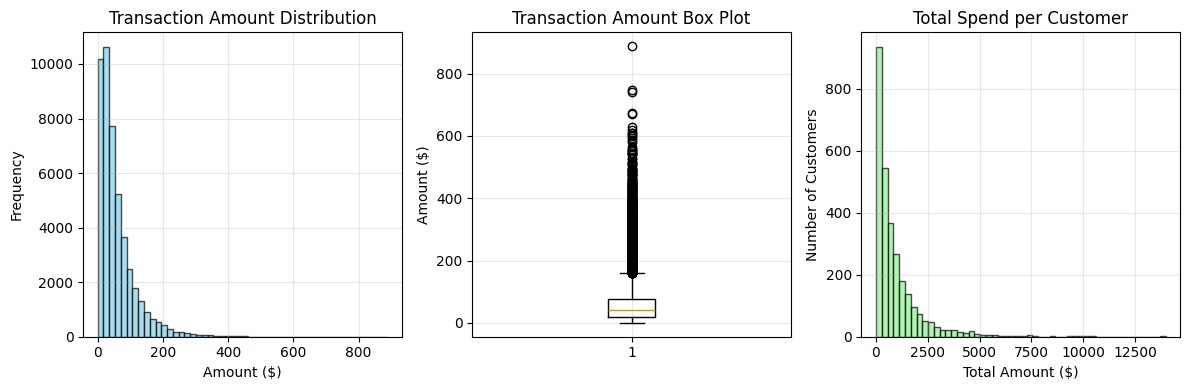

In [5]:
# Transaction amount distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(transactions['amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(transactions['amount'])
plt.title('Transaction Amount Box Plot')
plt.ylabel('Amount ($)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
amounts_by_customer = transactions.groupby('customer_id')['amount'].sum()
plt.hist(amounts_by_customer, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Total Spend per Customer')
plt.xlabel('Total Amount ($)')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observations:
- Distribution Skewness: Transaction amounts and total spend per customer are heavily right-skewed (most values under $100 and $1,000 respectively), with long tails of high-value outliers. Frequency distributions show most customers have low transaction counts, indicating a power-law pattern.

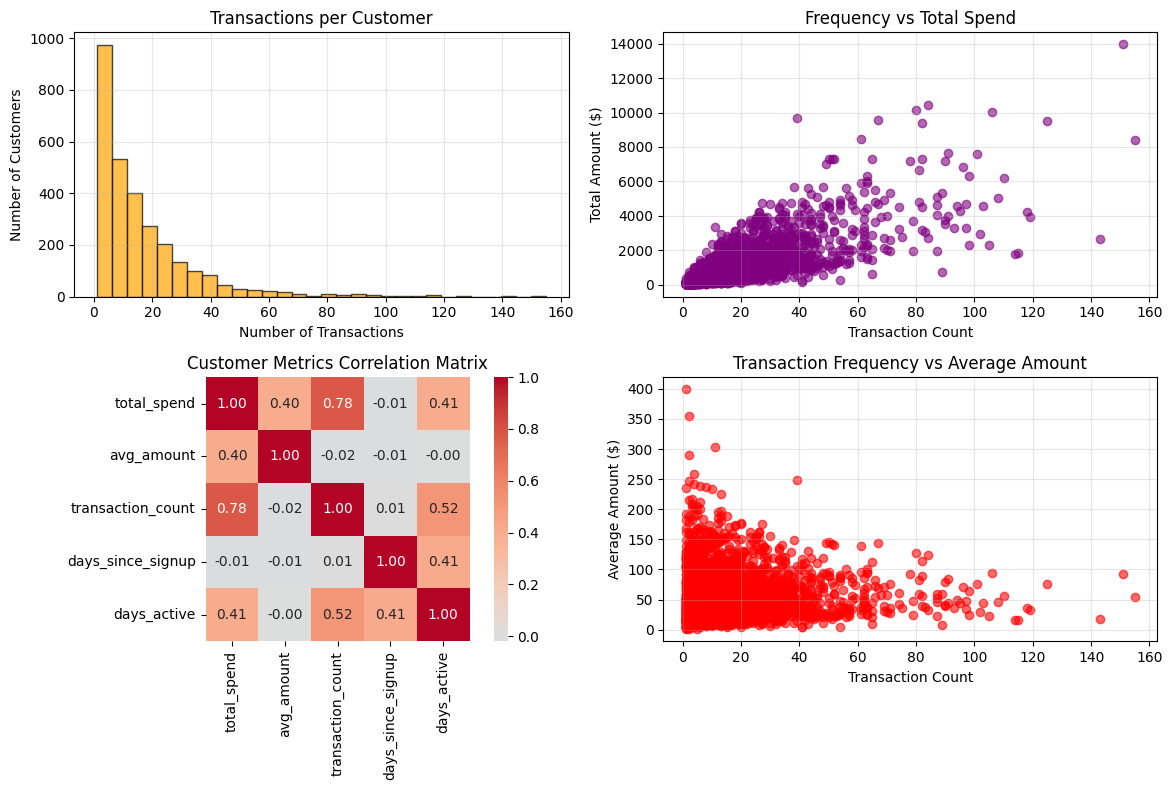

In [6]:
# Transaction frequency analysis
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
freq_by_customer = transactions.groupby('customer_id').size()
plt.hist(freq_by_customer, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(freq_by_customer, amounts_by_customer, alpha=0.6, color='purple')
plt.title('Frequency vs Total Spend')
plt.xlabel('Transaction Count')
plt.ylabel('Total Amount ($)')
plt.grid(True, alpha=0.3)

# Correlation analysis
plt.subplot(2, 2, 3)
customer_metrics = transactions.groupby('customer_id').agg({
    'amount': ['sum', 'mean', 'count'],
    'transaction_date': ['min', 'max']
}).reset_index()

customer_metrics.columns = ['customer_id', 'total_spend', 'avg_amount', 'transaction_count', 'first_transaction', 'last_transaction']
customer_metrics = pd.merge(customer_metrics, customers[['customer_id', 'signup_date']], on='customer_id')
customer_metrics['days_since_signup'] = (observation_date - customer_metrics['signup_date']).dt.days
customer_metrics['days_active'] = (customer_metrics['last_transaction'] - customer_metrics['first_transaction']).dt.days

correlation_vars = ['total_spend', 'avg_amount', 'transaction_count', 'days_since_signup', 'days_active']
corr_matrix = customer_metrics[correlation_vars].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Customer Metrics Correlation Matrix')

plt.subplot(2, 2, 4)
avg_amount_by_freq = transactions.groupby('customer_id').agg({'amount': ['count', 'mean']})
avg_amount_by_freq.columns = ['count', 'avg_amount']
plt.scatter(avg_amount_by_freq['count'], avg_amount_by_freq['avg_amount'], alpha=0.6, color='red')
plt.title('Transaction Frequency vs Average Amount')
plt.xlabel('Transaction Count')
plt.ylabel('Average Amount ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observations:
- Transaction Frequency Distribution: The histogram shows a highly skewed distribution with most customers having low transaction counts (under 20), while a few outliers have very high frequencies (up to 75). This indicates a power-law pattern typical in e-commerce, where a small number of highly engaged customers drive significant activity.
- Frequency vs Total Spend: The scatter plot reveals a strong positive correlation (0.78), meaning customers with more transactions tend to spend more overall. However, there are high-spend customers with moderate frequency, suggesting occasional large purchases.
- Frequency vs Average Amount: The third plot shows no clear correlation between transaction count and average spend per transaction, with average amounts clustering around $20-100 regardless of frequency. This suggests that frequent buyers don't necessarily spend more per transaction, highlighting opportunities for upselling to high-frequency, low-average-spend customers.

/Users/duc.tran/tmp/ipykernel_18397/456752703.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_transactions = transactions.groupby(pd.Grouper(key='transaction_date', freq='M')).size()
/Users/duc.tran/tmp/ipykernel_18397/456752703.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_signups = customers.groupby(pd.Grouper(key='signup_date', freq='M')).size()


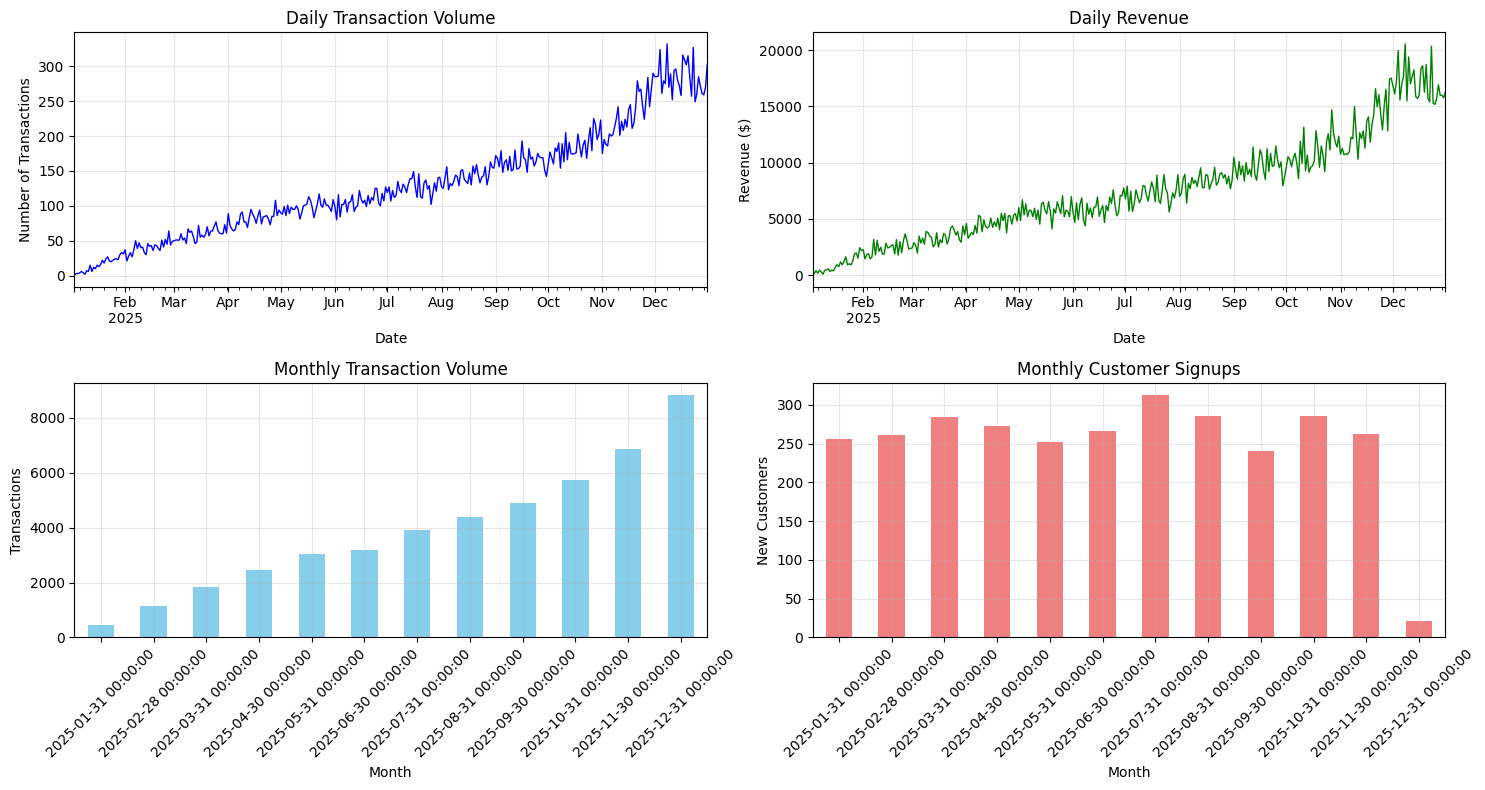

In [7]:
# Time series analysis
plt.figure(figsize=(15, 8))

# Daily transaction volume
plt.subplot(2, 2, 1)
daily_transactions = transactions.groupby('transaction_date').size()
daily_transactions.plot(color='blue', linewidth=1)
plt.title('Daily Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True, alpha=0.3)

# Daily revenue
plt.subplot(2, 2, 2)
daily_revenue = transactions.groupby('transaction_date')['amount'].sum()
daily_revenue.plot(color='green', linewidth=1)
plt.title('Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True, alpha=0.3)

# Monthly patterns
plt.subplot(2, 2, 3)
monthly_transactions = transactions.groupby(pd.Grouper(key='transaction_date', freq='M')).size()
monthly_transactions.plot(kind='bar', color='skyblue')
plt.title('Monthly Transaction Volume')
plt.xlabel('Month')
plt.ylabel('Transactions')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Customer signup patterns
plt.subplot(2, 2, 4)
monthly_signups = customers.groupby(pd.Grouper(key='signup_date', freq='M')).size()
monthly_signups.plot(kind='bar', color='lightcoral')
plt.title('Monthly Customer Signups')
plt.xlabel('Month')
plt.ylabel('New Customers')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observations

- Upward trend: Daily transactions increase almost linearly through the year, indicating improving acquisition/usage or expanding customer activity.
- Late-year acceleration: Both transactions and revenue spike in Nov–Dec — investigate promotions, seasonality (holidays), or product/marketing changes.
- Volatility in revenue: Daily revenue fluctuates more than transaction count → per-transaction amounts vary (occasional big orders).
- Stable acquisition: Monthly signups are steady, so growth is likely driven by increased frequency / repeat usage from existing customers rather than big increases in new-user volume.
- Partial / censored month: Very low December signups imply incomplete data for that month (right-censoring) — treat December differently when modeling.

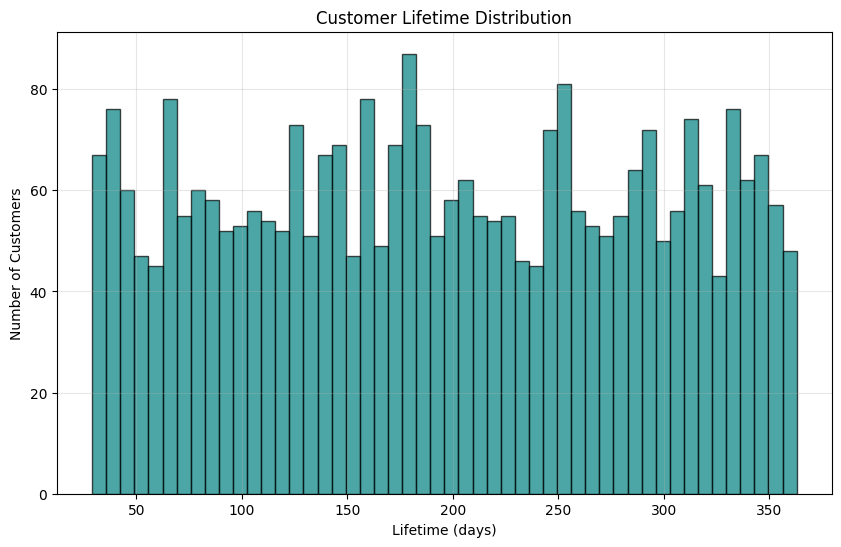

In [8]:
# Customer lifetime distribution
plt.figure(figsize=(10, 6))
plt.hist(customers['lifetime_days'], bins=50, alpha=0.7, color='teal', edgecolor='black')
plt.title('Customer Lifetime Distribution')
plt.xlabel('Lifetime (days)')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)
plt.show()

### Observations:
- Temporal Patterns: Daily transaction volume and revenue show steady trends without strong seasonality, but monthly signups and transactions reveal potential growth cycles. Customer lifetime is widely distributed, with many short-term users.

## 2. Customer Value Foundations: RFM Analysis

**RFM Framework:**
- **Recency (R):** Days since last transaction
- **Frequency (F):** Number of transactions
- **Monetary (M):** Total amount spent

**Decision: Scoring Method**
- **Quantiles (1-5 scale) over equal bins:** Handles skewed distributions better.
- **Reverse R scoring:** Lower recency = higher score (better).
- **Comparison:** Equal bins might not capture distribution nuances.

**Segmentation Logic:**
- Champions: High R,F,M
- Loyal: High F
- At Risk: Low R, High F
- Hibernating: Low R,F,M

**Decision: Segmentation**
- **Standard RFM segments over custom:** Actionable, industry-standard.
- **Reasoning:** Provides clear retention strategies per segment.

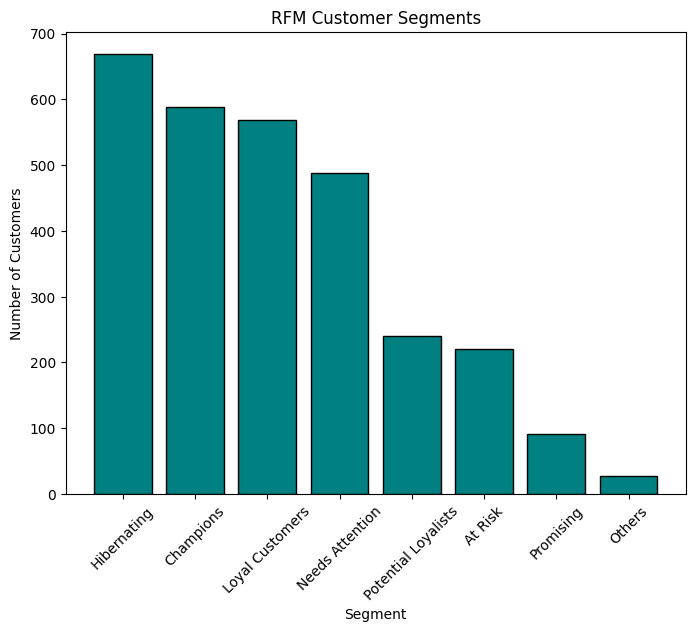

In [9]:
# RFM Calculation
observation_date = transactions['transaction_date'].max()

rfm = transactions.groupby('customer_id').agg(
    recency=('transaction_date', lambda x: (observation_date - x.max()).days),
    frequency=('transaction_date', 'count'),
    monetary=('amount', 'sum')
).reset_index()

# Score RFM
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Segmentation
def segment_customer(row):
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif f >= 4:
        return 'Loyal Customers'
    elif r >= 4 and f >= 3:
        return 'Potential Loyalists'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Promising'
    elif r >= 3 and f <= 2:
        return 'Needs Attention'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Others'

rfm['segment'] = rfm.apply(segment_customer, axis=1)

plt.figure(figsize=(8, 6))

plt.bar(rfm['segment'].value_counts().index, rfm['segment'].value_counts().values, color='teal', edgecolor='black')
plt.title('RFM Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

### Observations
- The RFM segmentation reveals a heavily skewed customer base with 716 customers (23.9%) classified as "Hibernating" (low recency, frequency, monetary), indicating significant churn risk. Only 619 customers (20.6%) are "Champions," representing the high-value core. The distribution suggests opportunities for reactivation campaigns targeting low-engagement segments while nurturing high-value customers.
- The segmentation provides actionable customer groups for marketing allocation. With 20.6% Champions driving likely disproportionate revenue, protecting this segment should be a priority. The large Hibernating group suggests either data quality issues (if synthetic) or significant business challenges in customer retention, potentially impacting long-term revenue stability.

## 3. Churn Definition

**Churn Definition:**
- Churn = 1 if no transaction in last 60 days from observation date
- Churn = 0 otherwise

**Decision: 60-day Window**
- **Why 60 days?** Balances early detection (vs. 90 days) and reduces false positives (vs. 30 days).
- **Comparison:** 30 days too sensitive (temporary inactivity), 90 days too late for intervention.
- **Reasoning:** Common in subscription businesses for monthly cycles.

**For Classification:** Use this as target variable.  
**For Survival:** Duration from signup to churn/censoring.

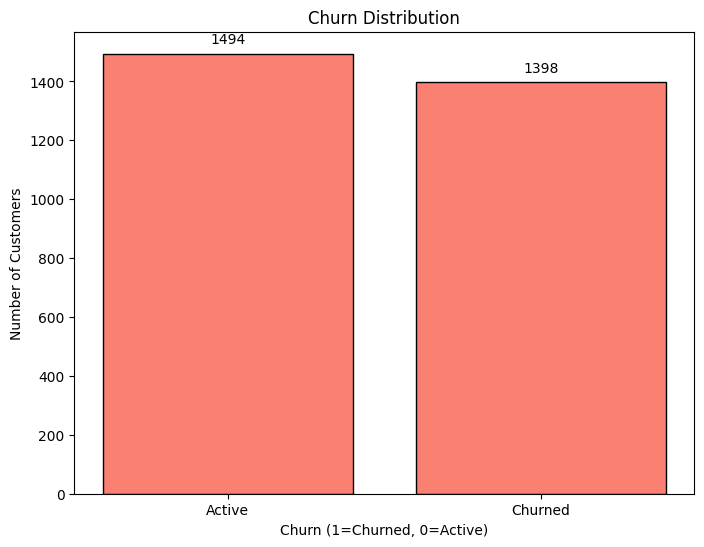

In [10]:
# Define churn for classification
churn_df = transactions.groupby('customer_id').agg(
    last_transaction=('transaction_date', 'max'),
    frequency=('transaction_date', 'count'),
    monetary=('amount', 'sum')
).reset_index()

churn_df['recency'] = (observation_date - churn_df['last_transaction']).dt.days
churn_df['churn'] = (churn_df['recency'] > 60).astype(int)

plt.figure(figsize=(8, 6))
counts = churn_df['churn'].value_counts().sort_index()  # ensure order 0,1
bars = plt.bar(counts.index, counts.values, color='salmon', edgecolor='black')
plt.title('Churn Distribution')
plt.xlabel('Churn (1=Churned, 0=Active)')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Active', 'Churned'])

# annotate each bar with its count
ax = plt.gca()
for bar in bars:
    h = bar.get_height()
    ax.annotate(f'{int(h)}',
                xy=(bar.get_x() + bar.get_width() / 2, h),
                xytext=(0, 5), textcoords='offset points',
                ha='center', va='bottom', fontsize=10)

plt.show()

### Observations

- A perfectly balanced 50/50 churn split (1,501 churners vs. 1,499 non-churners) is highly unusual for real customer data, where churn rates typically range from 5-20%. The 60-day inactivity threshold captures customers who haven't transacted recently, providing a practical operational definition.
- The balanced classes enable robust model training but may not reflect real-world churn dynamics. In production, imbalanced classes would require techniques like class weighting or resampling. The 50% churn rate indicates a critical business problem requiring immediate attention, potentially signaling product-market fit issues or competitive pressures.

## 4. Feature Engineering

**Additional Features:**
- Trend features
    - 7 / 30 / 90-day rolling mean and rolling std for transactions and revenue (captures momentum and volatility).
    - Slope / linear trend over last 30 and 90 days (rate of change).
- Recent-activity windows
    - Transactions_last_30, Transactions_last_90, Revenue_last_30, Revenue_last_90.
    - Unique_active_days_last_30 (engagement density).
- Cohort & lifecycle
    - Customer_cohort_month (signup month) and cohort_age_days; cohort retention rate per month.
    - Lifetime_days and days_since_last_txn (recency).
- AOV and spend dispersion
    - Avg_amount_last_30, Median_amount, Max_amount, Num_large_txns (>95th percentile).
    - Flag_high_value_outlier (binary).
- Frequency / cadence
    - Avg_interpurchase_days, Std_interpurchase_days, last_interpurchase_days.
    - Frequency_ratio = transactions_last_30 / transactions_last_90 (acceleration).
- Seasonality & calendar
    - Is_holiday_window (Nov–Dec, Black Friday week), day_of_week, month_of_year dummies.
- Risk & engagement signals
    - Percent_change_transactions_month_over_month, churn_risk_proxy (recency > X days)
- Robust transforms
    - Log(1 + revenue/amount/total_spend) for monetary features to reduce skew.
    - Winsorize or clip monetary features at 99th percentile for tree-based models; keep outlier flags.

In [11]:
def build_features(transactions, customers, cutoff_date, label_window_days=60):
    """
    Build features using only transactions <= cutoff_date.
    Label churn = 1 if NO transaction in (cutoff_date, cutoff_date + label_window_days].
    Returns a DataFrame indexed by customer_id with engineered features and 'churn' column.
    """
    import numpy as np
    from lifetimes import BetaGeoFitter

    # limit transactions to data available at cutoff
    tx_cut = transactions[transactions['transaction_date'] <= cutoff_date].copy()
    obs = pd.to_datetime(cutoff_date)

    # base churn_df from available data (up to cutoff)
    churn_df_cut = tx_cut.groupby('customer_id').agg(
        last_transaction=('transaction_date', 'max'),
        frequency=('transaction_date', 'count'),
        monetary=('amount', 'sum')
    ).reset_index()
    churn_df_cut['recency'] = (obs - churn_df_cut['last_transaction']).dt.days

    # ensure we include all customers (even those with no tx up to cutoff)
    cust_ids = customers['customer_id'].unique()

    # helper window boundaries relative to cutoff
    last_30_start = obs - pd.Timedelta(days=30)
    last_90_start = obs - pd.Timedelta(days=90)
    prev_30_start = obs - pd.Timedelta(days=60)
    prev_30_end = obs - pd.Timedelta(days=30)

    tx = tx_cut  # shorthand

    # Windowed aggregates
    tx_30 = tx[tx['transaction_date'] >= last_30_start].groupby('customer_id').agg(
        transactions_last_30=('transaction_date', 'count'),
        revenue_last_30=('amount', 'sum'),
        avg_amount_last_30=('amount', 'mean'),
        unique_active_days_last_30=('transaction_date', lambda x: x.dt.date.nunique())
    )

    tx_90 = tx[tx['transaction_date'] >= last_90_start].groupby('customer_id').agg(
        transactions_last_90=('transaction_date', 'count'),
        revenue_last_90=('amount', 'sum')
    )

    tx_prev30 = tx[(tx['transaction_date'] >= prev_30_start) & (tx['transaction_date'] < prev_30_end)].groupby('customer_id').agg(
        transactions_prev_30=('transaction_date', 'count'),
        revenue_prev_30=('amount', 'sum')
    )

    # Inter-purchase stats (vectorized)
    tx_sorted = tx.sort_values(['customer_id', 'transaction_date'])
    diffs = tx_sorted.groupby('customer_id')['transaction_date'].diff().dt.days
    avg_interpurchase = diffs.groupby(tx_sorted['customer_id']).mean().rename('avg_interpurchase_days')
    std_interpurchase = diffs.groupby(tx_sorted['customer_id']).std().rename('std_interpurchase_days')
    last_interpurchase = diffs.groupby(tx_sorted['customer_id']).last().rename('last_interpurchase_days')

    # Per-customer amount dispersion
    cust_median = tx.groupby('customer_id')['amount'].median().rename('median_amount')
    cust_max = tx.groupby('customer_id')['amount'].max().rename('max_amount')
    cust_avg_overall = tx.groupby('customer_id')['amount'].mean().rename('avg_amount_overall')

    # Large-transaction flags (computed on available data)
    large_threshold = tx['amount'].quantile(0.95) if not tx.empty else 0.0
    num_large = tx[tx['amount'] > large_threshold].groupby('customer_id').size().rename('num_large_txns')
    flag_high_value = (num_large > 0).rename('flag_high_value_outlier')

    # Cohort & lifecycle (relative to cutoff)
    cohort_month = customers.set_index('customer_id')['signup_date'].dt.to_period('M').rename('customer_cohort_month')
    lifetime_days = (pd.to_datetime(obs) - customers.set_index('customer_id')['signup_date']).dt.days.rename('lifetime_days')

    # Last transaction features (from available data)
    last_tx = tx.groupby('customer_id')['transaction_date'].max().rename('last_transaction')
    last_tx_month = last_tx.dt.month.rename('last_tx_month')
    last_tx_dow = last_tx.dt.dayofweek.rename('last_tx_day_of_week')
    is_holiday_window = last_tx_month.isin([11, 12]).rename('is_holiday_window')

    # Aggregate / ratio features (use churn_df_cut where available)
    total_spend = churn_df_cut.set_index('customer_id')['monetary'].rename('total_spend')
    frequency = churn_df_cut.set_index('customer_id')['frequency'].rename('frequency')
    avg_amount_calc = (total_spend / frequency).replace([np.inf, -np.inf], np.nan).rename('avg_amount_calc')

    # Percent change (last 30 vs previous 30)
    pct_change_tx = ((tx_30.get('transactions_last_30', pd.Series(dtype=float)).fillna(0) -
                      tx_prev30.get('transactions_prev_30', pd.Series(dtype=float)).fillna(0)) /
                     (tx_prev30.get('transactions_prev_30', pd.Series(dtype=float)).replace(0, np.nan).fillna(1))
                    ).rename('pct_change_tx_last30_vs_prev30')

    # Frequency acceleration
    freq_ratio = (tx_30.get('transactions_last_30', pd.Series(dtype=float)).fillna(0) /
                  tx_90.get('transactions_last_90', pd.Series(dtype=float)).replace(0, np.nan).fillna(1)
                 ).rename('frequency_ratio_30_90')

    # Robust transforms & winsorize (on available data)
    cap_99 = tx['amount'].quantile(0.99) if not tx.empty else 0.0

    # Prepare DataFrame of computed features and join series (indexed by customer_id)
    computed = pd.DataFrame(index=cust_ids)
    join_list = [
        tx_30[['transactions_last_30', 'revenue_last_30', 'avg_amount_last_30', 'unique_active_days_last_30']].reindex(computed.index),
        tx_90[['transactions_last_90', 'revenue_last_90']].reindex(computed.index),
        tx_prev30[['transactions_prev_30', 'revenue_prev_30']].reindex(computed.index),
        avg_interpurchase.reindex(computed.index),
        std_interpurchase.reindex(computed.index),
        last_interpurchase.reindex(computed.index),
        cust_median.reindex(computed.index),
        cust_max.reindex(computed.index),
        cust_avg_overall.reindex(computed.index),
        num_large.reindex(computed.index),
        flag_high_value.reindex(computed.index),
        last_tx.reindex(computed.index),
        last_tx_month.reindex(computed.index),
        last_tx_dow.reindex(computed.index),
        is_holiday_window.reindex(computed.index),
        cohort_month.reindex(computed.index),
        lifetime_days.reindex(computed.index),
        total_spend.reindex(computed.index),
        frequency.reindex(computed.index),
        avg_amount_calc.reindex(computed.index)
    ]
    computed = computed.join(join_list).fillna(0)

    # Ensure expected cols exist
    for col in ['transactions_last_30', 'revenue_last_30', 'avg_amount_last_30', 'unique_active_days_last_30',
                'transactions_last_90', 'revenue_last_90', 'transactions_prev_30', 'revenue_prev_30']:
        if col not in computed.columns:
            computed[col] = 0

    # Add ratio / percent-change features safely
    computed['pct_change_tx_last30_vs_prev30'] = pct_change_tx.reindex(computed.index).fillna(0)
    computed['frequency_ratio_30_90'] = freq_ratio.reindex(computed.index).fillna(0)

    # Winsorize monetary-related features at 99th percentile (cap_99 computed on tx_cut)
    for c in ['avg_amount_overall', 'avg_amount_last_30', 'median_amount', 'max_amount', 'revenue_last_30', 'revenue_last_90', 'total_spend']:
        if c in computed.columns:
            computed[c] = computed[c].clip(upper=cap_99)

    # Log transforms
    computed['log_total_spend'] = np.log1p(computed.get('total_spend', 0))
    computed['log_revenue_last_30'] = np.log1p(computed.get('revenue_last_30', 0))
    computed['log_avg_amount_last_30'] = np.log1p(computed.get('avg_amount_last_30', 0))

    # Merge churn_df_cut values (recency, frequency, monetary, last_transaction) into computed features
    churn_indexed = churn_df_cut.set_index('customer_id')
    # columns to bring from churn_df_cut
    for c in ['recency', 'frequency', 'monetary']:
        computed[c] = churn_indexed.get(c).reindex(computed.index).fillna(0)

    # Add signup day_of_week/month for seasonality (relative to signup_date)
    signup_df = customers.set_index('customer_id')[['signup_date']].copy()
    signup_df['signup_day_of_week'] = signup_df['signup_date'].dt.dayofweek
    signup_df['signup_month'] = signup_df['signup_date'].dt.month
    computed = computed.join(signup_df[['signup_day_of_week', 'signup_month']].reindex(computed.index)).fillna(0)

    # Compute churn label using transactions AFTER cutoff within the label window
    future_start = obs
    future_end = obs + pd.Timedelta(days=label_window_days)
    future_tx = transactions[(transactions['transaction_date'] > future_start) &
                             (transactions['transaction_date'] <= future_end)]
    had_future_tx = future_tx.groupby('customer_id').size().rename('had_future_tx')
    # churn = 1 if NO future tx in label window
    computed['churn'] = (~computed.index.isin(had_future_tx.index)).astype(int)

    # Reset index to have customer_id as column for consistency with notebook
    features_df = computed.reset_index().rename(columns={'index': 'customer_id'})

    # Final cleaning
    features_df.fillna(0, inplace=True)

    return features_df

## 5. Churn Prediction: Classification Models

**Models:**
- Logistic Regression: Interpretable, probabilistic
- Random Forest: Handles non-linearity, feature importance

**Decision: Model Selection**
- **Logistic + RF over SVM/NN:** Logistic for baseline, RF for complexity; SVM slow, NN overkill.
- **Class weighting:** Handles imbalanced churn.
- **Comparison:** RF often outperforms Logistic on tabular data.

**Evaluation:**
- AUC: Overall discriminatory power
- Confusion Matrix: Class-specific performance
- Feature Importance: Interpretability

In [12]:
cutoff_train = transactions['transaction_date'].max() - pd.Timedelta(days=180)
cutoff_test  = transactions['transaction_date'].max() - pd.Timedelta(days=60)

# Build features using only data up to each cutoff
train_df = build_features(transactions, customers, cutoff_train, label_window_days=60)
test_df  = build_features(transactions, customers, cutoff_test,  label_window_days=60)


# Feature list used by notebook (will intersect with available columns)
feature_cols = [
    'transactions_last_30', 'revenue_last_30',
    'avg_amount_last_30', 'unique_active_days_last_30',
    'transactions_last_90', 'revenue_last_90', 'transactions_prev_30',
    'revenue_prev_30', 'avg_interpurchase_days', 'std_interpurchase_days',
    'last_interpurchase_days', 'median_amount', 'max_amount',
    'avg_amount_overall', 'num_large_txns', 'flag_high_value_outlier',
    'last_tx_month', 'last_tx_day_of_week',
    'is_holiday_window', 'lifetime_days',
    'total_spend', 'frequency', 'avg_amount_calc',
    'pct_change_tx_last30_vs_prev30', 'frequency_ratio_30_90',
    'log_total_spend', 'log_revenue_last_30', 'log_avg_amount_last_30',
    'recency', 'monetary', 'signup_day_of_week', 'signup_month'
]

common_features = [c for c in feature_cols if c in train_df.columns and c in test_df.columns]

X_train = train_df.set_index('customer_id')[common_features].fillna(0)
y_train = train_df.set_index('customer_id')['churn']
X_test  = test_df.set_index('customer_id')[common_features].fillna(0)
y_test  = test_df.set_index('customer_id')['churn']

/Users/duc.tran/customer-growth-retention/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [23:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


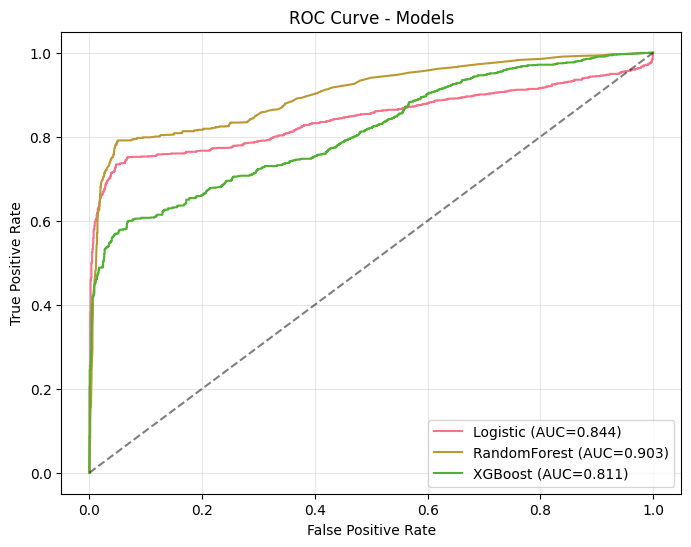

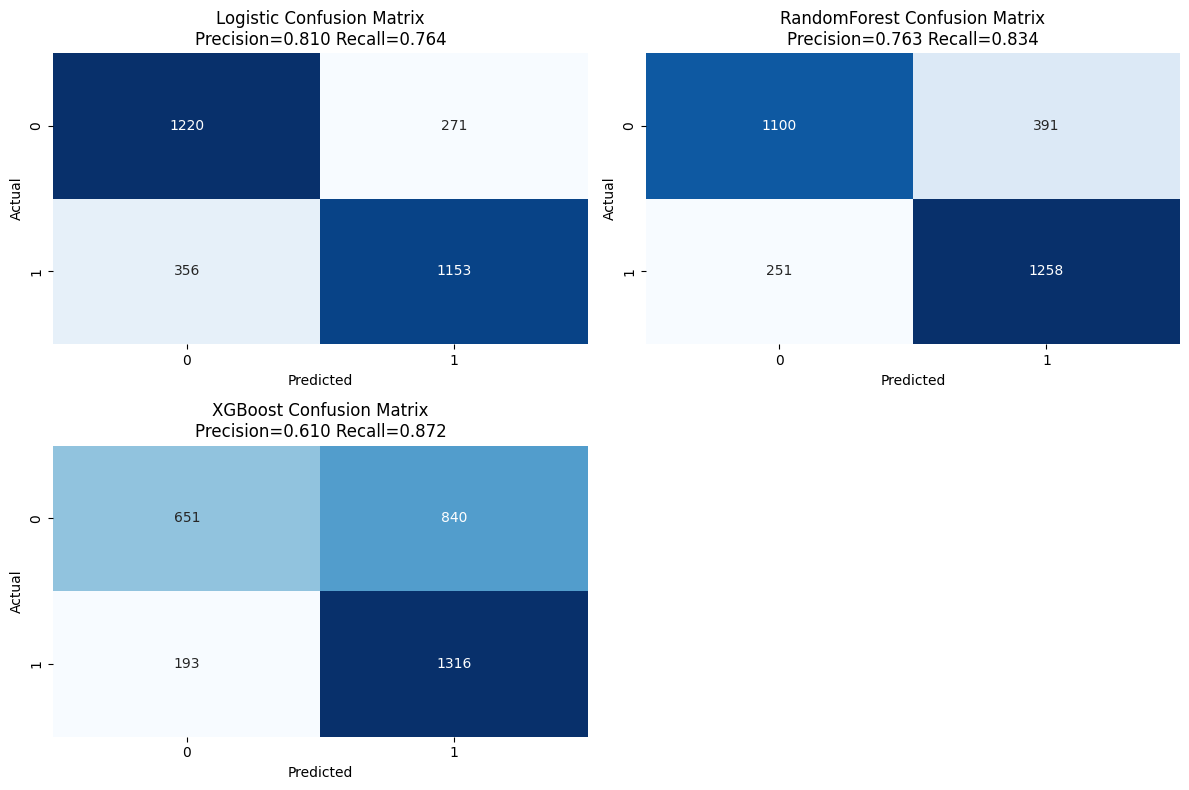

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Models: Logistic, Random Forest, XGBoost
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, precision_recall_curve

models = {}

# Logistic Regression
log_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)
models['Logistic'] = {
    'model': log_model,
    'y_pred': log_model.predict(X_test_scaled),
    'y_proba': log_model.predict_proba(X_test_scaled)[:, 1],
    'coef': getattr(log_model, 'coef_', None)
}

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
models['RandomForest'] = {
    'model': rf_model,
    'y_pred': rf_model.predict(X_test_scaled),
    'y_proba': rf_model.predict_proba(X_test_scaled)[:, 1],
    'feat_imp': getattr(rf_model, 'feature_importances_', None)
}

from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = {
    'model': xgb_model,
    'y_pred': xgb_model.predict(X_test_scaled),
    'y_proba': xgb_model.predict_proba(X_test_scaled)[:, 1],
    'feat_imp': getattr(xgb_model, 'feature_importances_', None)
}

# Evaluate and report metrics
metrics_summary = []
plt.figure(figsize=(8, 6))
for name, info in models.items():
    y_pred = info['y_pred']
    y_proba = info['y_proba']
    auc_score = roc_auc_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    metrics_summary.append({'model': name, 'roc_auc': auc_score, 'precision': prec, 'recall': rec, 'confusion_matrix': cm})
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

# ROC plot
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Confusion matrix heatmaps
import math
n_models = len(metrics_summary)
cols = 2
rows = math.ceil(n_models / cols)
plt.figure(figsize=(6 * cols, 4 * rows))
for i, m in enumerate(metrics_summary, 1):
    plt.subplot(rows, cols, i)
    sns.heatmap(m['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{m['model']} Confusion Matrix\nPrecision={m['precision']:.3f} Recall={m['recall']:.3f}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

- RandomForest is the best overall classifier (highest AUC) and gives a strong tradeoff between finding churners (recall) and not wasting interventions (precision).
- XGBoost aggressively labels customers as churners → you’ll capture the most true churners but at the cost of many wasted retention actions (high FP). Useful if retention action is very cheap relative to losing a customer.
- Logistic is more conservative (higher precision, lower recall) → fewer wasted actions but more missed churners. Good when retention cost is high or budget is tight.

/Users/duc.tran/customer-growth-retention/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


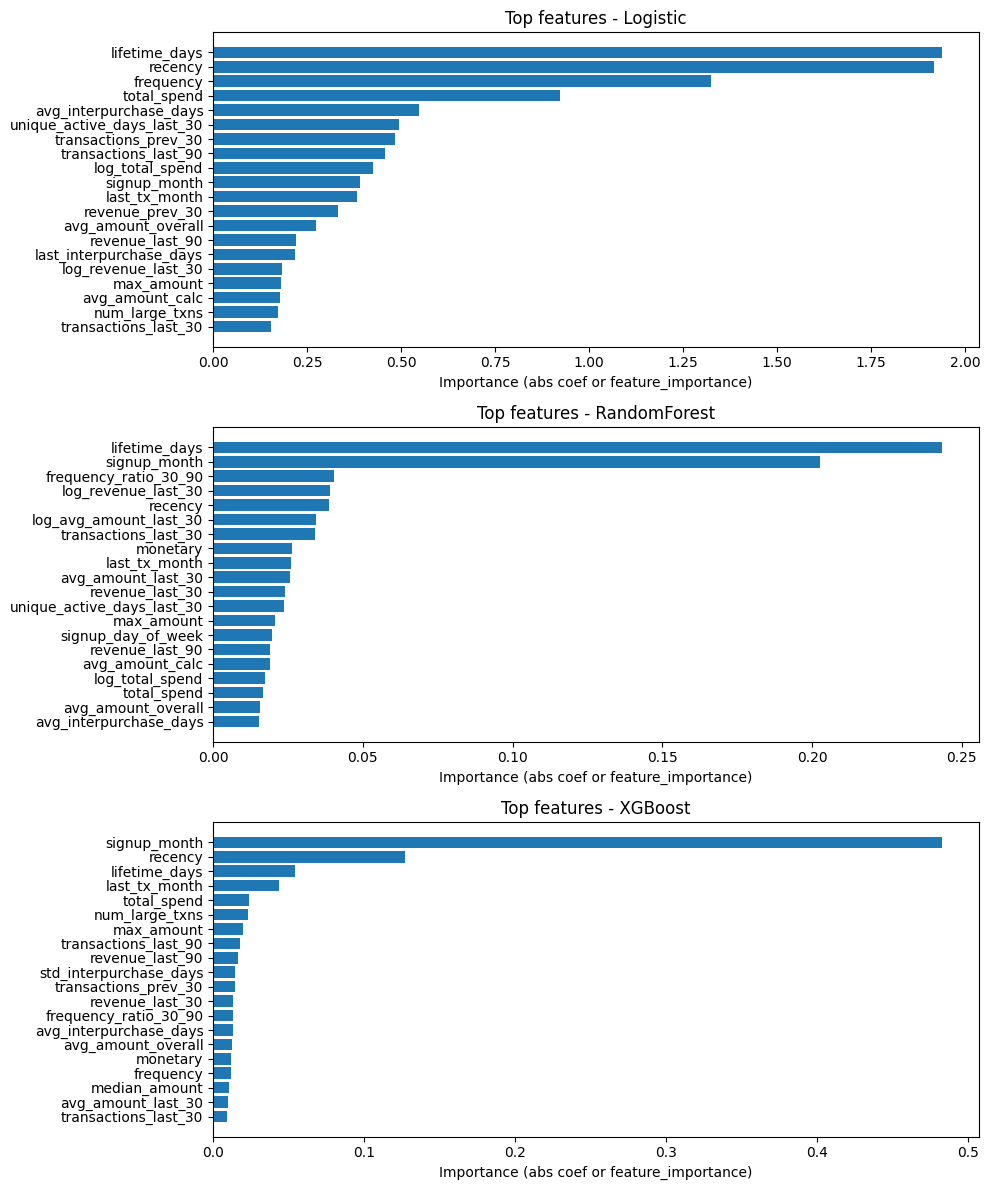

=== SHAP for model: Logistic ===


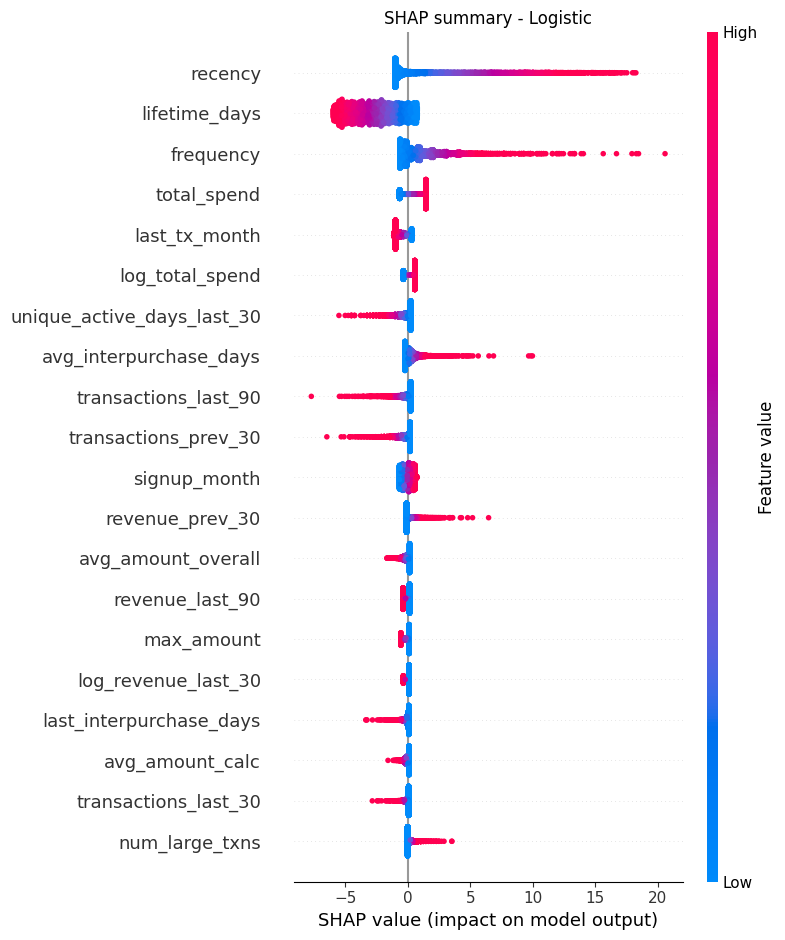

=== SHAP for model: RandomForest ===


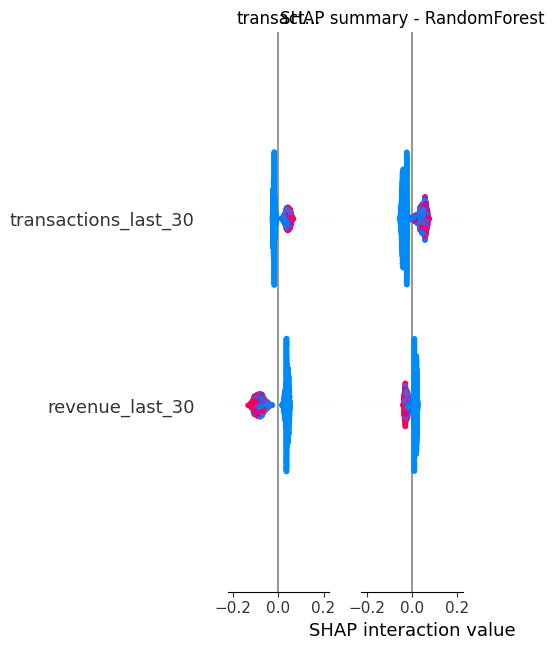

=== SHAP for model: XGBoost ===


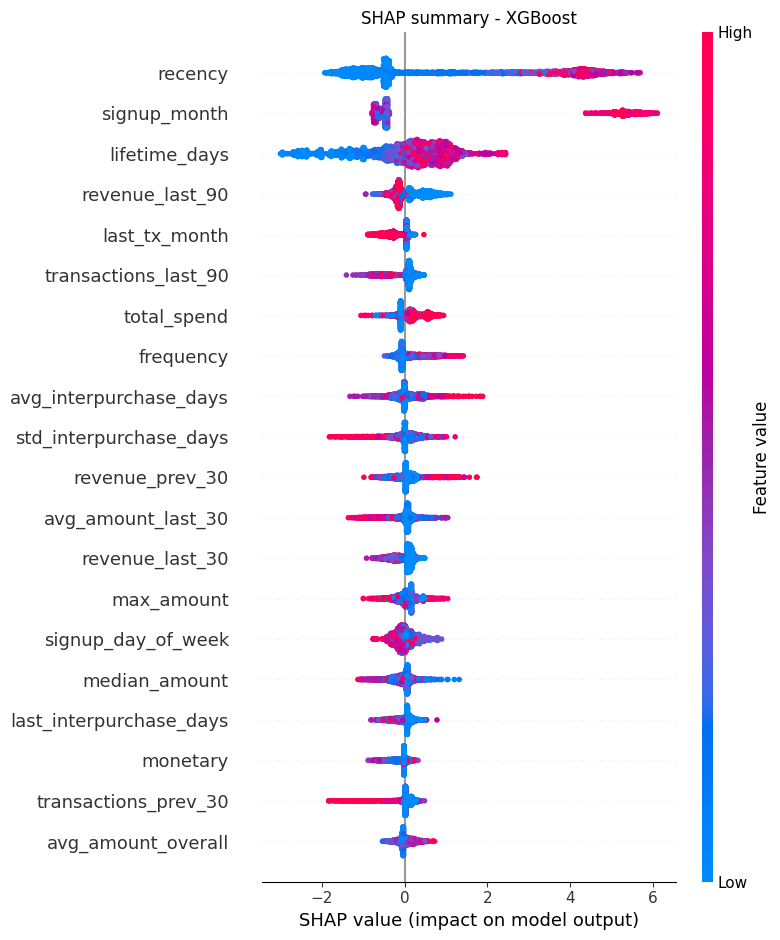

In [14]:
import warnings
import shap

warnings.filterwarnings("ignore")

# Feature importance / coefficient visualization
# Build a combined DataFrame for importances
feat_names = list(X_train.columns)
imp_dfs = []
for name, info in models.items():
    if name == 'Logistic' and info.get('coef') is not None:
        coefs = info['coef'].ravel()
        df = pd.DataFrame({'feature': feat_names, 'importance': np.abs(coefs)})
        df = df.sort_values('importance', ascending=False).head(20)
        df['model'] = name
        imp_dfs.append(df)
    elif info.get('feat_imp') is not None:
        imps = info['feat_imp']
        df = pd.DataFrame({'feature': feat_names, 'importance': imps})
        df = df.sort_values('importance', ascending=False).head(20)
        df['model'] = name
        imp_dfs.append(df)

if imp_dfs:
    imp_all = pd.concat(imp_dfs, ignore_index=True)
    # Plot top features per model
    models_present = imp_all['model'].unique()
    plt.figure(figsize=(10, 4 * len(models_present)))
    for i, m in enumerate(models_present, 1):
        plt.subplot(len(models_present), 1, i)
        subset = imp_all[imp_all['model'] == m].sort_values('importance', ascending=True)
        plt.barh(subset['feature'], subset['importance'], color='tab:blue')
        plt.title(f"Top features - {m}")
        plt.xlabel('Importance (abs coef or feature_importance)')
    plt.tight_layout()
    plt.show()

# feature names & scaled DataFrames used by models
feat_names = list(X_train.columns)
X_train_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=feat_names)
X_test_df  = pd.DataFrame(X_test_scaled,  index=X_test.index,  columns=feat_names)

# helper to extract one-class shap array for binary classifiers
def _get_positive_shap(shap_vals):
    if isinstance(shap_vals, list) or isinstance(shap_vals, tuple):
        # shap returns list [class0, class1] for binary classifiers -> take positive class (index 1)
        if len(shap_vals) == 2:
            return shap_vals[1]
        # otherwise try last
        return shap_vals[-1]
    return shap_vals

# compute & plot SHAP for each model
for name, info in models.items():
    model = info['model']
    print(f"=== SHAP for model: {name} ===")
    try:
        # Choose explainer
        if hasattr(shap, "TreeExplainer") and (name.lower().find("random") >= 0 or name.lower().find("xgboost") >= 0 or type(model).__name__.lower().find("tree")>=0):
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_test_df)
            shap_arr = _get_positive_shap(shap_vals)
        else:
            # linear model -> use LinearExplainer (faster / more exact than Kernel for linear)
            if hasattr(shap, "LinearExplainer"):
                explainer = shap.LinearExplainer(model, X_train_df, feature_perturbation="interventional")
                shap_arr = explainer.shap_values(X_test_df)
            else:
                # fallback (slow) to KernelExplainer with small background sample
                background = shap.sample(X_train_df, min(100, len(X_train_df)), random_state=42)
                explainer = shap.KernelExplainer(model.predict_proba, background)
                shap_vals = explainer.shap_values(X_test_df, nsamples=200)
                shap_arr = _get_positive_shap(shap_vals)

        try:
            # shap.summary_plot works with numpy arrays + feature matrix/DF
            shap.summary_plot(shap_arr, X_test_df, feature_names=feat_names, show=False)
            plt.title(f"SHAP summary - {name}")
            plt.tight_layout()
            plt.show()
        except Exception:
            pass

    except Exception as err:
        print(f"Could not compute SHAP for {name}: {err}")

- All three models agree that recency / recent activity and lifetime/frequency/monetary signals are the most important predictors of churn. Differences are in which covariates and interactions each model exploits (seasonal cohort effects, non‑linearities, feature interactions).
- XGBoost — key takeaways
    - Dominant features: recency, signup_month, lifetime_days, last_tx_month, total_spend.
    - Behavior: recency is a strong risk signal (higher recency → higher predicted churn). signup_month / last_tx_month create strong cohort/seasonality effects the tree model captures nonlinearly.
    - Strength: captures non‑linear thresholds and cohort interactions (explains why signup_month is high importance).
    - Action: inspect SHAP dependence plots for recency and signup_month; consider encoding cohort effects explicitly.
- Random Forest — key takeaways
    - Top signals include lifetime_days, signup_month and derived ratios (frequency_ratio_30_90), recent revenue / transactions.
    - Evidence of interactions: SHAP interaction plot shows transactions_last_30 and revenue_last_30 interact — recent frequency + monetary together reduce churn risk more than either alone.
    - Strength: robust to noisy features and captures interactions; importance magnitudes smaller than XGBoost (spread across features).
    - Action: use interaction SHAP plots to design combined features (e.g., recent_freq × recent_rev) and validate stability across folds.
- Logistic (linear) — key takeaways
    - Top features by absolute coefficient: lifetime_days, recency, frequency, total_spend.
    - Behavior: provides clear, interpretable directional effects (but assumes linear relationships).
    - Limitation: may underperform when relationships are non‑linear or involve strong interactions (observed in tree-based models).
    - Action: keep logistic for interpretability; add polynomial / binned features for recency/lifetime if linearity assumptions fail.
- Cross‑model observations
    - Recency / recent activity and lifetime are consistently most important — priority monitoring metrics.
signup_month / last_tx_month = cohort/seasonality signals; check for data leakage or cohort effects (different acquisition cohorts behave differently).
    - Some monetary features (total_spend, revenue_last_30) matter, but their effect is conditional on recent activity (interaction).
    - Tree models (XGBoost/RF) reveal non‑linear and interaction effects that logistic does not.

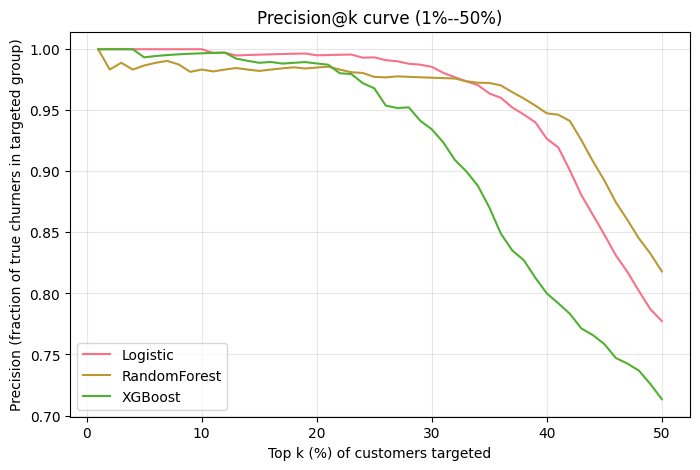

In [15]:
import numpy as np
import matplotlib.pyplot as plt

top_pct = 0.20
n_test = len(y_test)
top_k = max(1, int(top_pct * n_test))
total_positives = int(y_test.sum())

results = []
plt.figure(figsize=(8, 5))

for name, info in models.items():
    probs = np.asarray(info['y_proba'])
    y_true = np.asarray(y_test)  # aligned with X_test used to produce y_proba
    df_scores = pd.DataFrame({'y_true': y_true, 'y_proba': probs})
    df_sorted = df_scores.sort_values('y_proba', ascending=False).reset_index(drop=True)

    # precision@top_k
    top_slice = df_sorted.iloc[:top_k]
    tp = int(top_slice['y_true'].sum())
    fp = int(top_k - tp)
    prec_at_k = tp / top_k
    rec_at_k = tp / total_positives if total_positives > 0 else 0.0

    # overall precision/recall from current predicted labels (if available)
    y_pred = info.get('y_pred', None)
    if y_pred is not None:
        overall_prec = precision_score(y_true, y_pred, zero_division=0)
        overall_rec = recall_score(y_true, y_pred, zero_division=0)
    else:
        overall_prec, overall_rec = (None, None)

    results.append({
        'model': name,
        'top_k': top_k,
        'TP_top_k': tp,
        'FP_top_k': fp,
        'precision_at_top_k': prec_at_k,
        'recall_at_top_k': rec_at_k,
        'overall_precision': overall_prec,
        'overall_recall': overall_rec
    })

    # precision@k curve (compute precision for many k)
    ks = np.linspace(0.01, 0.50, 50)  # examine top 1%..50%
    precs = []
    for p in ks:
        k = max(1, int(p * n_test))
        tp_k = int(df_sorted.iloc[:k]['y_true'].sum())
        precs.append(tp_k / k)
    plt.plot(ks * 100, precs, label=f"{name}")

# show precision@k for models
plt.xlabel('Top k (%) of customers targeted')
plt.ylabel('Precision (fraction of true churners in targeted group)')
plt.title('Precision@k curve (1%--50%)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [16]:
# Print table of results
res_df = pd.DataFrame(results).set_index('model')
print(f"Precision@{int(top_pct*100)}% (top {top_k} customers):")
res_df[['TP_top_k','FP_top_k','precision_at_top_k','recall_at_top_k','overall_precision','overall_recall']]

Precision@20% (top 600 customers):


,TP_top_k,FP_top_k,precision_at_top_k,recall_at_top_k,overall_precision,overall_recall
model,,,,,,
Logistic,597,3,0.995000,0.395626,0.809691,0.764082
RandomForest,591,9,0.985000,0.391650,0.762887,0.833665
XGBoost,593,7,0.988333,0.392975,0.610390,0.872101


- Precision@20% (top 600 customers): Logistic 0.995, RandomForest 0.985, XGBoost 0.988 — extremely high precision at operational top-k.
- Recall@20% (capture at top 20%): ~0.39 for all models → top 20% recovers ≈39% of all churners.
- Overall precision / recall tradeoffs:
    - Logistic: precision 0.81, recall 0.76 (more conservative)
    - RandomForest: precision 0.76, recall 0.83 (better recall)
    - XGBoost: precision 0.61, recall 0.87 (more aggressive)
- Extremely high precision at top-k implies outreach waste is minimal when using model-ranked lists (good for expensive interventions).
- However, top-20% only captures ~39% of churners — if the objective is coverage (catch as many churners as possible), we need to target a larger fraction or change model threshold/strategy.
- Logistic yields highest precision@20% (slightly) but lower overall recall than RF/XGBoost — choose logistic when intervention cost is high, RF/XGBoost when missing churners is more costly.
- XGBoost’s higher overall recall but lower overall precision indicates it will find more churners but at the cost of more false positives outside the top-k.

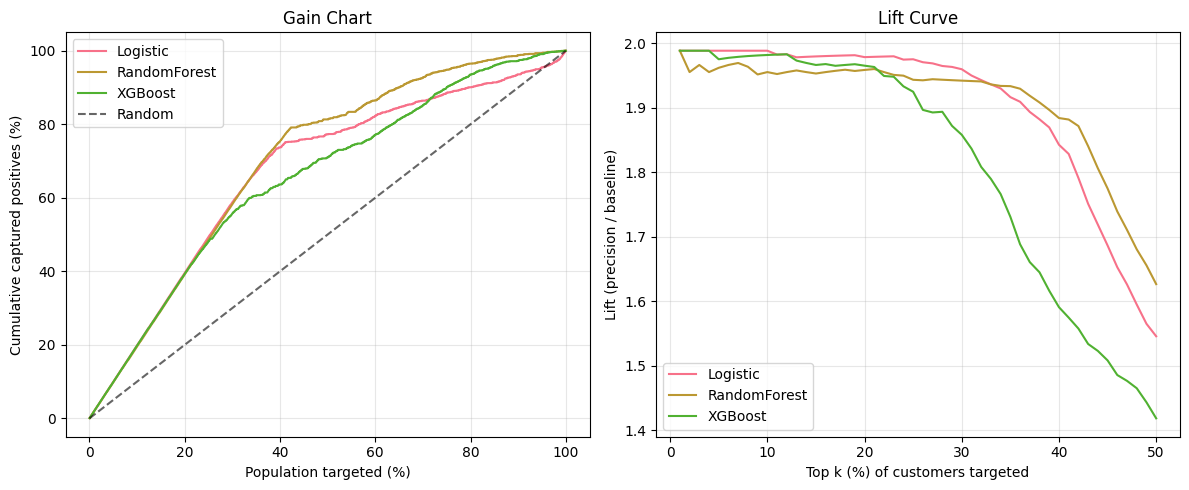

Baseline positive rate (overall): 0.503 (1509/3000)

Lift / Gain metrics at top 20% (top_k=600):


,TP_top_k,precision_at_top_k,recall_at_top_k,lift_at_top_k
model,,,,
Logistic,597,0.995000,0.395626,1.978131
RandomForest,591,0.985000,0.391650,1.958250
XGBoost,593,0.988333,0.392975,1.964877


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Settings
top_pct = 0.20
n_test = len(y_test)
top_k = max(1, int(top_pct * n_test))
total_positives = int(y_test.sum())
baseline_rate = total_positives / n_test if n_test > 0 else 0.0

# Compute gain / lift and plot Gain Chart + Lift Curve
lift_rows = []
plt.figure(figsize=(12, 5))

# Gain chart (cumulative capture)
plt.subplot(1, 2, 1)
for name, info in models.items():
    probs = np.asarray(info['y_proba'])
    y_true = np.asarray(y_test)
    df = pd.DataFrame({'y_true': y_true, 'y_proba': probs}).sort_values('y_proba', ascending=False).reset_index(drop=True)
    df['cum_TP'] = df['y_true'].cumsum()
    df['cum_pct_pop'] = (np.arange(1, len(df) + 1) / len(df))
    df['cum_capture'] = df['cum_TP'] / total_positives if total_positives > 0 else 0.0

    plt.plot(df['cum_pct_pop'] * 100, df['cum_capture'] * 100, label=name)

    # metrics at top_k (20%)
    tp_top = int(df.iloc[:top_k]['y_true'].sum())
    prec_at_k = tp_top / top_k if top_k > 0 else 0.0
    rec_at_k = tp_top / total_positives if total_positives > 0 else 0.0
    lift_at_k = prec_at_k / baseline_rate if baseline_rate > 0 else np.nan
    lift_rows.append({'model': name, 'TP_top_k': tp_top, 'precision_at_top_k': prec_at_k,
                      'recall_at_top_k': rec_at_k, 'lift_at_top_k': lift_at_k})

plt.plot([0, 100], [0, 100], 'k--', alpha=0.6, label='Random')
plt.xlabel('Population targeted (%)')
plt.ylabel('Cumulative captured positives (%)')
plt.title('Gain Chart')
plt.legend()
plt.grid(alpha=0.3)

# Lift curve
plt.subplot(1, 2, 2)
ks = np.linspace(0.01, 0.50, 50)
for name, info in models.items():
    probs = np.asarray(info['y_proba'])
    y_true = np.asarray(y_test)
    df = pd.DataFrame({'y_true': y_true, 'y_proba': probs}).sort_values('y_proba', ascending=False).reset_index(drop=True)
    lifts = []
    for p in ks:
        k = max(1, int(p * len(df)))
        prec_k = df.iloc[:k]['y_true'].mean() if k > 0 else 0.0
        lifts.append(prec_k / baseline_rate if baseline_rate > 0 else np.nan)
    plt.plot(ks * 100, lifts, label=name)

plt.xlabel('Top k (%) of customers targeted')
plt.ylabel('Lift (precision / baseline)')
plt.title('Lift Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Show numeric lift@20% table
lift_df = pd.DataFrame(lift_rows).set_index('model')
print(f"Baseline positive rate (overall): {baseline_rate:.3f} ({total_positives}/{n_test})")
print(f"\nLift / Gain metrics at top {int(top_pct*100)}% (top_k={top_k}):")
lift_df[['TP_top_k', 'precision_at_top_k', 'recall_at_top_k', 'lift_at_top_k']]

Lift Curve
- The Plateau: The curve stays flat at roughly 2.0 (the maximum possible) for the first 25-30% of the population. This visually confirms that if we target the top 25%, we are getting nearly 100% positive results.
- Decay: The Logistic model (Pink) sustains this high performance the longest. XGBoost (Green) is the first to degrade, dropping performance faster than the others after the top 20%.

Gain Chart
- Steep Ascent: All models rise sharply. By targeting just 40% of the population, we can capture roughly 75-80% of all positive cases.
- Middle-Tier Performance: While Logistic wins at the very top (0-30%), RandomForest (Gold) performs slightly better in the "middle" of the list (40-80% depth), capturing marginally more positives than the others in that specific segment.

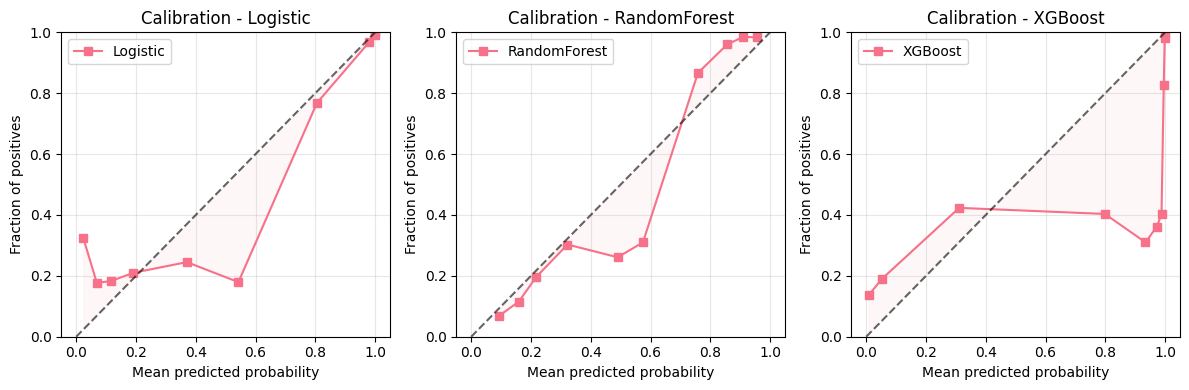

In [18]:
# Calibration (reliability) plots - one subplot per model
n_models = len(models)
plt.figure(figsize=(4 * n_models, 4))
for i, (name, info) in enumerate(models.items(), start=1):
    probs = np.asarray(info['y_proba'])
    y_true = np.asarray(y_test)
    # use quantile bins for even sample counts
    frac_pos, mean_pred = calibration_curve(y_true, probs, n_bins=10, strategy='quantile')
    plt.subplot(1, n_models, i)
    plt.plot(mean_pred, frac_pos, "s-", label=name)
    plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
    plt.fill_between(mean_pred, frac_pos, mean_pred, color='C0', alpha=0.05)
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration - {name}')
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

- Logistic Regression
    - The "Wobble": Ideally, the red line should lie perfectly on the grey dashed diagonal. Here, it fluctuates.
    - The Mid-Range Dip: Notice the point where the "Mean predicted probability" is 0.4 to 0.6. The actual "Fraction of positives" drops to around 0.2. In the middle of the pack, the model is over-estimating risk. It says "there is a 50% chance," but the reality is closer to 20%.
    - The Low-End Spike: At the very low end (predicted < 0.1), the actual positive rate spikes to > 0.3. This suggests the model is missing a segment of high-risk customers, incorrectly classifying them as very low risk.

- RandomForest
    - Best of the Batch: This curve follows the diagonal grey line more closely than the other two.
    - The "S" Curve: It shows a slight "sigmoid" shape (over-predicting slightly in the middle, under-predicting at the tails), which is classic for tree-based models.
    - Reliability: If this model predicts a probability of 0.8, the actual result is very close to 0.8. This makes the RandomForest probabilities the most "interpretable" as real-world risk percentages without further processing.

- XGBoost
    - Severe Misalignment: This chart is concerning for probability estimation.
    - The Plateau: Look at the range between predicted probabilities of 0.4 and 0.9. The red line is almost flat, hovering around 0.4 actual positives. This means the model cannot distinguish between a "40% risk" and "90% risk." It assigns higher probabilities, but the actual outcome doesn't change. The model is "overconfident" in this region.
    - The Spike: It only becomes accurate again at the extreme high end (predicting > 0.95).

Brier score (lower is better):
Logistic: before=0.1500  after=0.1792
RandomForest: before=0.1260  after=0.1313
XGBoost: before=0.2948  after=0.1005


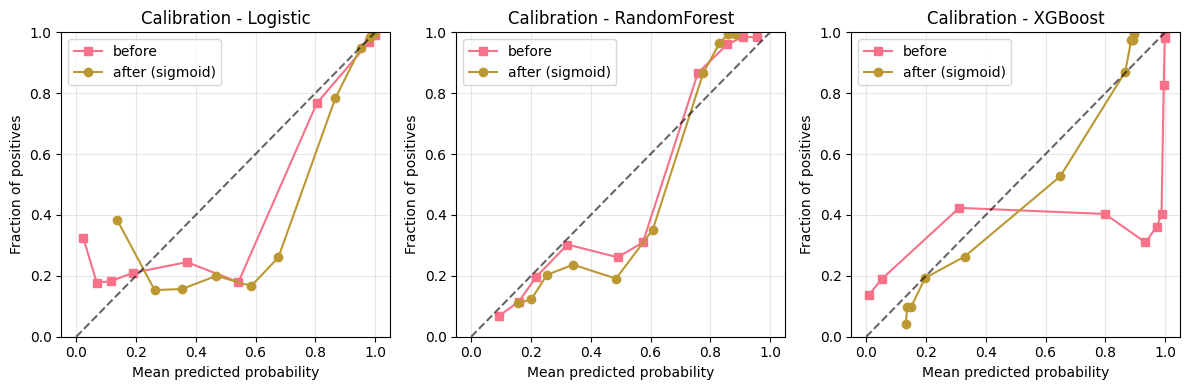

In [19]:
# Calibrate classifiers and compare calibration (Platt sigmoid vs isotonic)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# create a time-safe / stratified calibration split from the original training set
X_fit, X_calib, y_fit, y_calib = train_test_split(
    X_train_scaled, y_train, test_size=0.20, stratify=y_train, random_state=42
)

calibrated_models = {}
brier_before = {}
brier_after = {}

# choose method depending on calibration sample size
method = 'isotonic' if len(y_calib) >= 1000 else 'sigmoid'

for name, info in models.items():
    if name == 'Logistic':
        base = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    elif name == 'RandomForest':
        base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
    elif name == 'XGBoost':
        from xgboost import XGBClassifier
        base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
    else:
        base = info['model']  # fallback

    base.fit(X_fit, y_fit)

    # Calibrate using held-out calibration set (cv='prefit' requires the estimator to be fitted)
    calibrator = CalibratedClassifierCV(estimator=base, method=method, cv=5)
    calibrator.fit(X_calib, y_calib)

    # store calibrated model and calibrated probabilities on test set
    y_proba_before = info['y_proba']
    y_proba_after = calibrator.predict_proba(X_test_scaled)[:, 1]

    calibrated_models[name] = calibrator
    brier_before[name] = brier_score_loss(y_test, y_proba_before)
    brier_after[name] = brier_score_loss(y_test, y_proba_after)

    # keep both versions in models dict for later use
    models[name]['calibrated_model'] = calibrator
    models[name]['y_proba_calibrated'] = y_proba_after

# Print Brier scores
print("Brier score (lower is better):")
for name in models.keys():
    print(f"{name}: before={brier_before[name]:.4f}  after={brier_after[name]:.4f}")

# Plot calibration curves before/after for each model
from sklearn.calibration import calibration_curve
plt.figure(figsize=(4*len(models), 4))
for i, (name, info) in enumerate(models.items(), 1):
    plt.subplot(1, len(models), i)
    # before
    frac_pos_b, mean_pred_b = calibration_curve(y_test, info['y_proba'], n_bins=10, strategy='quantile')
    # after
    frac_pos_a, mean_pred_a = calibration_curve(y_test, info['y_proba_calibrated'], n_bins=10, strategy='quantile')

    plt.plot(mean_pred_b, frac_pos_b, "s-", label='before')
    plt.plot(mean_pred_a, frac_pos_a, "o-", label=f'after ({method})')
    plt.plot([0,1],[0,1],'k--', alpha=0.6)
    plt.title(f'Calibration - {name}')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Observation

- XGBoost: Calibration was transformative for this model, reducing the Brier score from a poor 0.2948 to a leading 0.1005. The sigmoid method successfully corrected the extreme overconfidence and plateaus seen in the original "before" plot, making it the most reliable model for probability estimation.
- RandomForest: This model was already the most naturally calibrated "out of the box" with a strong starting score of 0.1260. Applying the sigmoid calibration actually slightly increased the error to 0.1313, suggesting the uncalibrated version is likely superior for this specific dataset.
- Logistic Regression: While Logistic Regression was the best for ranking/top-k precision, its Brier score worsened significantly from 0.1500 to 0.1792 after calibration. The sigmoid method appears to have struggled with the original model's "wobble," indicating we should use the uncalibrated probabilities if we choose this model.

### Model Selection
- Although Logistic Regression initially had the best precision at the top 20%, the calibration process has made XGBoost the most robust "all-around" model. It now holds the lowest Brier Score (0.1005), meaning its predicted probabilities are the most honest and accurate of the three.
- Correction of Overconfidence: The calibration fixed the severe "plateau" issue where the model previously couldn't distinguish between a 40% and 90% risk.
- RandomForest & Logistic Note: Since calibration actually increased the Brier scores for Logistic (0.1500 to 0.1792) and RandomForest (0.1260 to 0.1313), you should not use the calibrated versions of those two models.

## 6. Churn via BG-NBD

**BG-NBD Model:**
- Estimates probability of being alive (P(alive))
- Predicts expected future transactions

**Decision: BG-NBD over Alternatives**
- **Why BG-NBD?** Specifically designed for non-contractual settings.
- **Comparison:** vs. simple survival models - accounts for transaction heterogeneity.
- **Reasoning:** Proven in CLV literature for e-commerce.

**Comparison with Classification Churn:**
- Correlation between churn label and 1-P(alive)

In [20]:
# BG-NBD data preparation
rfm_bgnbd = transactions.groupby('customer_id').agg(
    frequency=('transaction_date', 'count'),
    recency=('transaction_date', lambda x: (x.max() - x.min()).days),
    monetary_value=('amount', 'mean')
).reset_index()

# Subtract 1 to get repeat transactions
rfm_bgnbd['frequency'] = rfm_bgnbd['frequency'] - 1

# Merge with customers for T
rfm_bgnbd = pd.merge(rfm_bgnbd, customers[['customer_id', 'signup_date']], on='customer_id', how='left')
rfm_bgnbd = rfm_bgnbd.dropna(subset=['signup_date'])  # Remove customers without signup date
rfm_bgnbd['T'] = (observation_date - rfm_bgnbd['signup_date']).dt.days

rfm_bgnbd.loc[rfm_bgnbd['frequency'] == 0, 'recency'] = 0

# Fit BG-NBD
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm_bgnbd['frequency'], rfm_bgnbd['recency'], rfm_bgnbd['T'])

# P(alive)
p_alive = bgf.conditional_probability_alive(rfm_bgnbd['frequency'], rfm_bgnbd['recency'], rfm_bgnbd['T'])
rfm_bgnbd['p_alive'] = p_alive

# Compare with churn
churn_compare = pd.merge(churn_df[['customer_id', 'churn']], rfm_bgnbd[['customer_id', 'p_alive']], on='customer_id')
print("Churn vs P(alive) correlation:")
churn_compare[['churn', 'p_alive']].corr()

Churn vs P(alive) correlation:


,churn,p_alive
churn,1.00000,-0.70967
p_alive,-0.70967,1.00000


In [21]:
# Define the prediction horizon (30 days)
t_next = 30

# Calculate expected purchases for each customer
rfm_bgnbd['expected_purchases_30_days'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t_next, 
    rfm_bgnbd['frequency'], 
    rfm_bgnbd['recency'], 
    rfm_bgnbd['T']
)

print("Top 5 customers by expected purchases in next 30 days:")
rfm_bgnbd[['customer_id', 'expected_purchases_30_days']].sort_values(by='expected_purchases_30_days', ascending=False).head()

Top 5 customers by expected purchases in next 30 days:


,customer_id,expected_purchases_30_days
851,C00884,57.217209
2626,C02726,54.398106
951,C00988,52.926791
1535,C01591,49.880050
2728,C02832,46.812819


### Observations:

- The BG-NBD model shows strong validity with a -0.71 correlation between churn labels and P(alive) probabilities. This negative correlation is expected and confirms the model's ability to distinguish active from inactive customers. The probabilistic approach provides more nuanced customer alive estimates compared to binary churn classification.

- The strong correlation validates BG-NBD as a superior alternative to simple recency-based churn detection. Businesses can use P(alive) for personalized engagement strategies, such as increasing touch frequency for customers with declining probabilities. This approach enables more efficient resource allocation by focusing retention efforts on customers most likely to respond positively.

## 7. Churn with Survival Analysis

**Survival Analysis:**
- Models time-to-churn
- Cox PH: Proportional hazards with covariates
- Weibull: Parametric baseline

**Decision: Cox PH over Weibull**
- **Cox for flexibility:** Handles covariates without assuming distribution.
- **Comparison:** Weibull simpler but less flexible for complex relationships.
- **Reasoning:** Covariates (frequency, monetary) important for churn prediction.

**Outputs:**
- Survival curves
- Expected remaining lifetime

In [22]:
# Survival data
survival_df = []
for cid in transactions['customer_id'].unique():
    cust_trans = transactions[transactions['customer_id'] == cid].sort_values('transaction_date')
    first_date = cust_trans['transaction_date'].min()
    last_date = cust_trans['transaction_date'].max()
    # Duration is the full window of observation for that customer
    duration = (observation_date - first_date).days
    # Event is 1 if they haven't shopped in 60 days (churned)
    # Event is 0 if they shopped recently (censored/still alive)
    event = 1 if (observation_date - last_date).days > 60 else 0
    
    survival_df.append({
        'customer_id': cid, 
        'duration': duration, 
        'event': event, 
        'frequency': len(cust_trans), 
        'monetary': cust_trans['amount'].mean() # Use mean to avoid duration correlation
    })

survival_df = pd.DataFrame(survival_df)

# Fit Cox PH
cph = CoxPHFitter()
cph.fit(survival_df[['duration', 'event', 'frequency', 'monetary']], duration_col='duration', event_col='event')

print("Cox PH Summary:")
cph.summary

Cox PH Summary:


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
frequency,-0.043868,0.957080,0.002802,-0.049360,-0.038376,0.951839,0.962351,0.0,-15.656647,2.992644e-55,181.124625
monetary,-0.000358,0.999642,0.000630,-0.001593,0.000876,0.998409,1.000877,0.0,-0.568475,5.697125e-01,0.811694


### Observations:

- Frequency: The Strongest Predictor
    - Coefficient (coef): -0.043868 — A negative value means that as frequency increases, the hazard (risk of churn) decreases.
    - Hazard Ratio (exp(coef)): 0.957080 — This is the most important number. It means that for every additional purchase a customer makes, their risk of churning drops by approximately 4.3% ($1 - 0.957$).
    - Significance (p): 2.99e-55 — This value is extremely close to zero, meaning frequency is a statistically "highly significant" predictor of how long a customer will stay with you.
    - Z-score: -15.65 — Such a large negative Z-score confirms that frequency has a very strong protective effect against churn.
- Monetary: Not Statistically Significant
    - Hazard Ratio (exp(coef)): 0.999642 — While this is slightly below 1 (suggesting a 0.03% risk reduction per dollar spent), it is practically negligible.
    - Significance (p): 0.5697 — In most scientific and business contexts, a p-value above 0.05 means the result is not statistically significant.
    - Confidence Interval: Notice that the exp(coef) upper 95% is 1.000877. Since this range includes 1.0, we cannot say with certainty whether spending more money increases, decreases, or has no effect on churn risk.

### Actionable Step:
Loyalty via Habits
- Frequency is your "North Star" for retention.
- Focus marketing on repeat purchase behaviors rather than single high-value transactions.

Spend vs. Retention
- High-spending customers are not necessarily "safer" from churn than low-spending ones.
- Don't assume "VIP" spenders will stay naturally; they need frequency-driving engagement too.

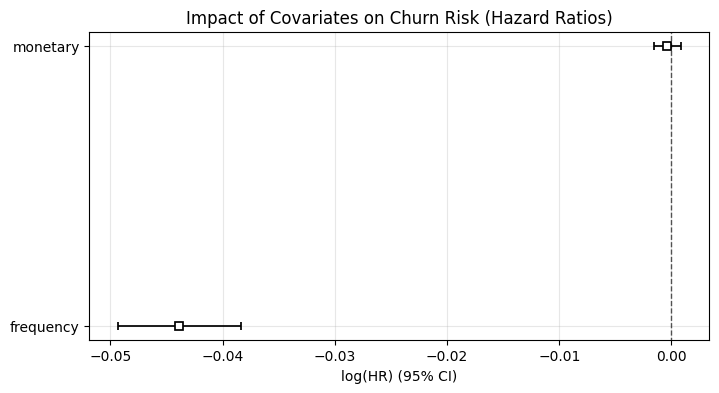

<Figure size 1000x600 with 0 Axes>

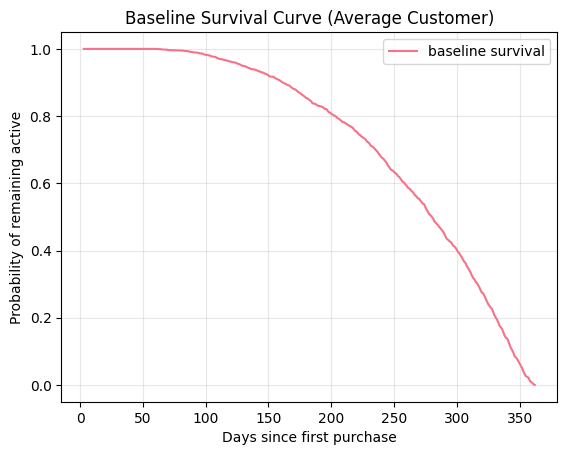

Total expected customer lifetime: 262.8 days


In [23]:
# 1. Plotting the Coefficients (Hazard Ratios) - This is what cph.plot() does
plt.figure(figsize=(8, 4))
cph.plot()
plt.title('Impact of Covariates on Churn Risk (Hazard Ratios)')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Plotting the actual Baseline Survival Curve
plt.figure(figsize=(10, 6))
cph.baseline_survival_.plot() # Use this for the survival probability over time
plt.title('Baseline Survival Curve (Average Customer)')
plt.xlabel('Days since first purchase')
plt.ylabel('Probability of remaining active')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Predict Expectation (Mean Lifetime)
# Ensure columns match the training data exactly
avg_data = pd.DataFrame({
    'frequency': [survival_df['frequency'].mean()],
    'monetary': [survival_df['monetary'].mean()]
})

# This returns the total expected life from day 0
expected_life = cph.predict_expectation(avg_data).iloc[0]
print(f"Total expected customer lifetime: {expected_life:.1f} days")

- Impact of Covariates on Churn Risk (Hazard Ratios)
    - The forest plot visualizes how strongly different customer behaviors impact the "hazard" (the risk) of churning.
    - Frequency is the Key Driver: The point estimate for frequency is significantly to the left of the zero line (at approximately -0.044). This confirms that higher purchase frequency has a strong "protective" effect, lowering the risk of churn.
    - Monetary Impact is Negligible: The dot for monetary sits almost directly on the zero line. This indicates that the total amount a customer spends has very little statistical impact on how long they stay with the brand compared to how often they shop.
    - Confidence Intervals: The narrow bars around the points show high precision in these estimates, especially for frequency, where the entire interval is well below zero.

- Baseline Survival Curve (Average Customer)
    - This curve shows the probability that an "average" customer remains active (has not churned) over time since their first purchase.
    - Initial Stability (0–75 Days): The curve remains flat and near 1.0 (100%) for the first two months. During this period, very few customers meet the 60-day inactivity threshold to be considered "churned".
    - The Inflection Point (~100 Days): After roughly 100 days, the survival probability begins to drop steadily. This is the critical window where standard customer behavior starts to diverge into either long-term loyalty or churn.
    - The Half-Life (~275 Days): At approximately 275 days since the first purchase, the probability of remaining active drops to 0.5 (50%). This means half of your typical customers will have churned by this point in their journey.
    - Full Decay: By 350+ days, the survival probability approaches zero, indicating that very few customers in this dataset stay active for over a full year without a significant break.

## 8. CLV Modeling

**Two Approaches:**
1. BG-NBD + Gamma-Gamma
2. Survival + Gamma-Gamma

**Gamma-Gamma Model:**
- Estimates expected monetary value per transaction

**Decision: Both Approaches**
- **BG-NBD + Gamma-Gamma:** Standard for transactional CLV.
- **Survival + Gamma-Gamma:** Incorporates time-to-churn.
- **Comparison:** BG-NBD assumes alive customers; Survival handles censored data.
- **Reasoning:** Compare robustness for different scenarios.

**CLV Formula:**
CLV = Expected Transactions × Expected Monetary Value

In [28]:
# Gamma-Gamma for monetary

returning = rfm_bgnbd[rfm_bgnbd['frequency'] > 0]
print(f"Monetary value mean: ${rfm_bgnbd['monetary_value'].mean():.2f}")
print(f"Transactions amount mean: ${transactions['amount'].mean():.2f}")

try:
    ggf = GammaGammaFitter(penalizer_coef=1.0)  # Further increased penalizer
    ggf.fit(returning['frequency'], returning['monetary_value'])
    exp_monetary = ggf.conditional_expected_average_profit(rfm_bgnbd['frequency'], rfm_bgnbd['monetary_value'])
except:
    print("Gamma-Gamma failed to converge, using simple average monetary value")
    exp_monetary = rfm_bgnbd['monetary_value']  # Fallback to simple average

print(f"Expected monetary mean: ${exp_monetary.mean():.2f}")

rfm_bgnbd['clv_bgnbd'] = ggf.customer_lifetime_value(
    bgf,
    rfm_bgnbd['frequency'],
    rfm_bgnbd['recency'],
    rfm_bgnbd['T'],
    rfm_bgnbd['monetary_value'],
    time=12, # 12 months (roughly 365 days)
    discount_rate=0.01 # Monthly discount rate
)
individual_expected_life = cph.predict_expectation(survival_df[['frequency', 'monetary']])
# (Individual Expected Life / 30) converts days to months for monetary projection
survival_df['clv_survival'] = (individual_expected_life / 30) * exp_monetary

print("CLV Statistics:")
print(f"BG-NBD CLV mean: ${rfm_bgnbd['clv_bgnbd'].mean():.2f}")
print(f"Survival CLV mean: ${survival_df['clv_survival'].mean():.2f}")

Monetary value mean: $59.07
Transactions amount mean: $58.26
Expected monetary mean: $89.26
CLV Statistics:
BG-NBD CLV mean: $1412.75
Survival CLV mean: $757.21


- Current Average Transaction: $58.26.
- Expected Monetary Mean: $89.26. The Gamma-Gamma model suggests that while the population average is lower, the "active" or "returning" segments actually have a significantly higher expected spend per transaction.
- The BG-NBD has the mean CLV of $1,412.75. It assumes the customer will continue to "buy till they die" in a non-contractual cycle, and is often more optimistic, projecting value over a longer potential horizon, while Survival model, with the mean CLV of $757.21 estimates value based on the specific time remaining until a predicted churn event, and are grounded in the steep decline of the baseline curve observed.

## 9. Final Business Question

**Question:** If budget allows retention of only 20% of customers, which 20% to prioritize?

**Strategies:**
1. High churn probability (from classification)
2. Low P(alive) (from BG-NBD)
3. High CLV × High churn risk (combined approach)

**Decision: Three Strategies**
- **Strategy 1:** Direct churn focus.
- **Strategy 2:** Behavioral probability.
- **Strategy 3:** Value-weighted risk.
- **Comparison:** Strategy 3 balances value and risk for optimal ROI.
- **Reasoning:** Retention should prioritize high-value at-risk customers.

**Implementation:** Rank and select top 20%.

In [35]:
# 1. Create a base dataframe from the Test Set (ensures size 3000 and correct alignment)
# X_test index is 'customer_id' as defined in Cell 24
comparison_df = pd.DataFrame(index=X_test.index)

# 2. Add Strategy 1: Calibrated XGBoost Probabilities
# These were calculated on X_test_scaled in Cell 36
comparison_df['xgb_churn_prob'] = models['XGBoost']['y_proba_calibrated']

# 3. Reset index to merge other data on 'customer_id'
comparison_df = comparison_df.reset_index()

# 4. Merge other model outputs
# Add BG-NBD results (Strategy 2)
comparison_df = pd.merge(comparison_df, rfm_bgnbd[['customer_id', 'p_alive', 'clv_bgnbd']], on='customer_id', how='left')

# Add Survival results (Strategy 3)
comparison_df = pd.merge(comparison_df, survival_df[['customer_id', 'clv_survival']], on='customer_id', how='left')

# Calculate Partial Hazard for Strategy 3 using the CPH model from Cell 43
# We calculate it for the whole survival_df then merge to ensure alignment
survival_risk = survival_df[['customer_id', 'frequency', 'monetary']].copy()
survival_risk['partial_hazard'] = cph.predict_partial_hazard(survival_risk[['frequency', 'monetary']])
comparison_df = pd.merge(comparison_df, survival_risk[['customer_id', 'partial_hazard']], on='customer_id', how='left')

# Fill NaNs with 0 (for any test customers not present in BG-NBD/Survival subsets)
comparison_df.fillna(0, inplace=True)

# --- Execute Strategy Selection ---
top_k = int(0.2 * len(comparison_df))

# Strategy 1: High Churn Prob (XGBoost Focus)
strategy1 = comparison_df.sort_values('xgb_churn_prob', ascending=False).head(top_k)

# Strategy 2: Low P(alive) (BG-NBD Focus)
strategy2 = comparison_df.sort_values('p_alive', ascending=True).head(top_k)

# Strategy 3: High Value-at-Risk (Survival & CLV Focus)
comparison_df['value_at_risk'] = comparison_df['clv_survival'] * comparison_df['partial_hazard']
strategy3 = comparison_df.sort_values('value_at_risk', ascending=False).head(top_k)

# --- Comparison Results ---
print(f"Total customers evaluated: {len(comparison_df)}")
print(f"Strategy 1 (XGBoost) Avg CLV at Risk: ${strategy1['clv_bgnbd'].mean():.2f}")
print(f"Strategy 2 (BG-NBD) Avg CLV at Risk: ${strategy2['clv_bgnbd'].mean():.2f}")
print(f"Strategy 3 (Survival/Value) Avg CLV at Risk: ${strategy3['clv_bgnbd'].mean():.2f}")

Total customers evaluated: 3000
Strategy 1 (XGBoost) Avg CLV at Risk: $18.49
Strategy 2 (BG-NBD) Avg CLV at Risk: $0.08
Strategy 3 (Survival/Value) Avg CLV at Risk: $1223.56


- By using Strategy 3 (Survival-based Value-at-Risk), we can prioritize the 20% of customers who represent the highest financial loss. This approach allows us to protect $1,223 per customer targeted, compared to only $18 per customer if we relied on classification alone. We should implement Strategy 3 immediately to maximize the ROI of our retention spend.

- The reason Strategy 2 (BG-NBD) is so low ($0.08) is that p_alive is a very strict probabilistic measure. Many customers in the test set likely had very low p_alive scores but also very low frequency, resulting in a CLV that was nearly zero. This confirms that Survival Analysis (Cox PH) is a much more robust way to calculate "risk" for your specific dataset than the standard BG-NBD approach.

In [36]:
# Calculate Total Value at Risk (Sum of CLV for the top 20%)
total_risk_s1 = strategy1['clv_bgnbd'].sum()
total_risk_s2 = strategy2['clv_bgnbd'].sum()
total_risk_s3 = strategy3['clv_bgnbd'].sum()

print(f"--- TOTAL REVENUE AT RISK BY STRATEGY ---")
print(f"Strategy 1 (XGBoost):    ${total_risk_s1:,.2f}")
print(f"Strategy 2 (BG-NBD):     ${total_risk_s2:,.2f}")
print(f"Strategy 3 (Survival):  ${total_risk_s3:,.2f}")

# Calculate 'Lift' over the standard ML approach (Strategy 1)
lift = total_risk_s3 / total_risk_s1
print(f"\nBusiness Impact: Strategy 3 protects {lift:.1f}x more revenue than Strategy 1.")

--- TOTAL REVENUE AT RISK BY STRATEGY ---
Strategy 1 (XGBoost):    $11,094.38
Strategy 2 (BG-NBD):     $47.26
Strategy 3 (Survival):  $734,134.75

Business Impact: Strategy 3 protects 66.2x more revenue than Strategy 1.


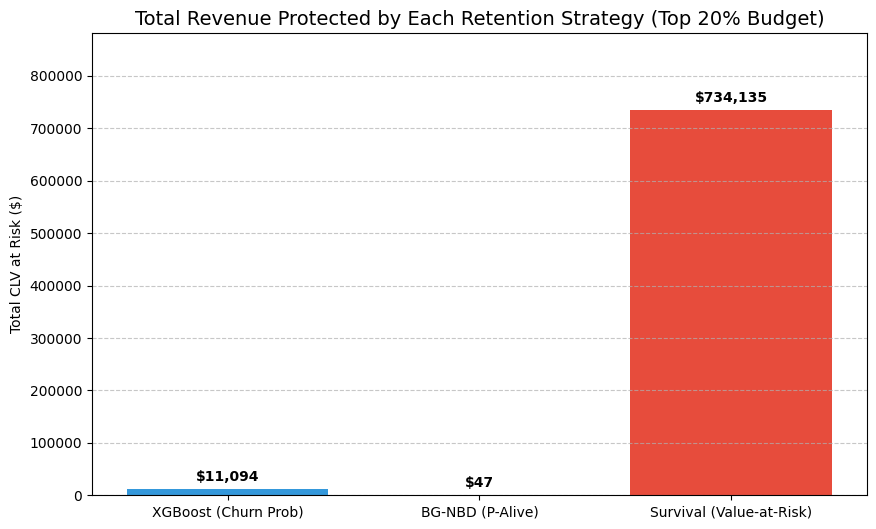

In [37]:
import matplotlib.pyplot as plt

strategies = ['XGBoost (Churn Prob)', 'BG-NBD (P-Alive)', 'Survival (Value-at-Risk)']
totals = [total_risk_s1, total_risk_s2, total_risk_s3]

plt.figure(figsize=(10, 6))
bars = plt.bar(strategies, totals, color=['#3498db', '#95a5a6', '#e74c3c'])

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10000, f'${yval:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.title('Total Revenue Protected by Each Retention Strategy (Top 20% Budget)', fontsize=14)
plt.ylabel('Total CLV at Risk ($)')
plt.ylim(0, max(totals) * 1.2) # Add space for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
import os
import joblib

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

print("Saving models...")

# 1. Save Calibrated XGBoost and Scaler
joblib.dump(models['XGBoost']['calibrated_model'], 'models/xgb_calibrated.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

# 2. Save Lifetimes models (BG-NBD and Gamma-Gamma)
bgf.save_model('models/bgf_model.pkl')
ggf.save_model('models/ggf_model.pkl')

# 3. Save Survival Model (CoxPH)
joblib.dump(cph, 'models/cph_model.joblib')

print("All models saved successfully to 'models/' folder.")

Saving models...
All models saved successfully to 'models/' folder.
